In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp

In [2]:
%load_ext autoreload
%autoreload 2
from lat_cb import quad
from lat_cb.cmbEB import all_cls_th

../lat_cb/quad.py:13: UserWarning: cmb_temp.py is only used for Carlos' EB studies and will be removed in future.
  from lat_cb import cmbEB


In [3]:
lib ='/pscratch/sd/l/lonappan/SOLAT'

In [4]:
qe = quad.QE(lib)

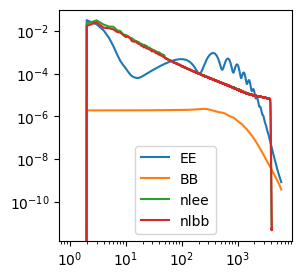

In [5]:
nlee,nlbb = qe.get_noise_cl()
plt.figure(figsize=(3,3))
plt.loglog(all_cls_th[:,1],label='EE')
plt.loglog(all_cls_th[:,2],label='BB')
plt.loglog(nlee,label='nlee')
plt.loglog(nlbb,label='nlbb')
plt.legend()

In [6]:
EB = qe.cinv_EB(0)

 B
           1
           2           1
  1.001084299169536E-005  0.539858520030975     
  6.895989827360463E-007  0.539858520030975     


../lat_cb/quad.py:126: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/(self.cl_len[2,:]),label='B theory')
../lat_cb/quad.py:127: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/(self.cl_len[1,:]),label='E theory')


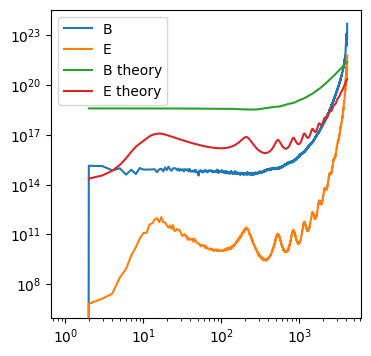

In [7]:
qe.plot_cinv(0)